#🏥Hospital Admmissions Data EDA

Integrantes:
*   Martina Gonzalez
*   Raquel Rehbein




🧠 1️⃣ Business Understanding (Comprensión del Negocio)
Contexto del problema

Las enfermedades cardiovasculares son una de las principales causas de hospitalización y mortalidad a nivel mundial.
El dataset proviene del Hero DMC Heart Institute (India) y contiene información de más de 12.000 pacientes hospitalizados entre 2017 y 2019, con variables demográficas, antecedentes clínicos, comorbilidades, parámetros de laboratorio y resultados hospitalarios (alta o fallecimiento).

El análisis de estos datos busca comprender los patrones asociados a la mortalidad hospitalaria y a la duración de las hospitalizaciones.

Hipótesis actualizada

“Factores clínicos, demográficos y ambientales influyen significativamente en la mortalidad hospitalaria y en la duración de la estancia hospitalaria. En particular, los pacientes con comorbilidades como diabetes, hipertensión o enfermedad cardíaca previa presentan una mayor probabilidad de fallecer o de requerir hospitalizaciones más prolongadas.”

Objetivos
🎯 Objetivo general

Desarrollar modelos predictivos de clasificación y regresión que permitan identificar patrones de riesgo y estimar desenlaces hospitalarios en pacientes con enfermedades cardiovasculares.

📌 Objetivos específicos

Construir un modelo de clasificación para predecir el desenlace hospitalario (fallecido / alta).

Construir un modelo de regresión para estimar la duración de la estancia hospitalaria (en días).

Evaluar y comparar el rendimiento de al menos 5 algoritmos diferentes por tipo de tarea, optimizando sus hiperparámetros mediante GridSearchCV + CrossValidation.

Analizar la importancia de las variables más influyentes en los desenlaces clínicos.

Integrar y versionar los resultados mediante Kedro, DVC, Airflow y Docker, garantizando la trazabilidad y reproducibilidad del flujo completo.

Valor del proyecto

Este proyecto permitirá:

Detectar factores de riesgo asociados a la mortalidad y a estancias prolongadas.

Apoyar la gestión hospitalaria, anticipando casos de mayor gravedad.

Integrar ciencia de datos aplicada a salud pública, con un pipeline reproducible y escalable.

Servir como base para un sistema de soporte a decisiones clínicas.

📊 2️⃣ Data Understanding (Comprensión de los Datos)

El proyecto utiliza tres fuentes de datos principales integradas por el número de paciente y la fecha de ingreso:

🏥 Admission Data

Contiene la información clínica y demográfica de los pacientes hospitalizados:

Identificación y tiempos: número de admisión, fechas de ingreso y alta, duración de estancia y de UCI.

Demografía: edad, género, procedencia (rural/urbana), tipo de admisión.

Estilo de vida: tabaquismo, alcohol.

Comorbilidades: diabetes (DM), hipertensión (HTN), enfermedad coronaria (CAD), miocardiopatía (CMP), enfermedad renal crónica (CKD).

Laboratorio: hemoglobina, leucocitos, plaquetas, glucosa, urea, creatinina, BNP, enzimas cardíacas.

Diagnósticos: insuficiencia cardíaca, angina, infarto, anemia, shock, infecciones, entre otros.

Resultado clínico: OUTCOME (alta, fallecido, alta voluntaria).

👉 Esta tabla es la base principal para el feature engineering de ambos modelos (clasificación y regresión).

⚰️ Mortality Data

Registra pacientes que fallecieron, con edad, género, procedencia y fecha del evento.
👉 Se usa para verificar y enriquecer el target de mortalidad hospitalaria.

🌍 Pollution Data

Incluye información ambiental diaria:

Índices de calidad del aire (AQI).

Contaminantes atmosféricos (PM2.5, PM10, NO₂, NH₃, SO₂, CO, Ozono).

Condiciones meteorológicas (temperaturas y humedad).

👉 Se relaciona por fecha de ingreso para analizar la influencia ambiental sobre los desenlaces hospitalarios.

Preguntas de investigación
🔹 Clasificación

¿Podemos predecir si un paciente hospitalizado por una enfermedad cardiovascular fallecerá o será dado de alta, en función de sus características clínicas, demográficas y comorbilidades?

📘 Objetivo del modelo: predecir el desenlace hospitalario (OUTCOME: alta = 0 / fallecido = 1).

🔹 Regresión

¿Podemos estimar cuántos días permanecerá hospitalizado un paciente, considerando sus condiciones clínicas, demográficas y de ingreso?

📘 Objetivo del modelo: predecir la duración de la estancia hospitalaria (DURATION OF STAY, variable continua).

https://www.kaggle.com/datasets/ashishsahani/hospital-admissions-data

###Importar librerias y cargar datos

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [2]:
from google.colab import files
import pandas as pd

# Subir primer archivo admission
uploaded = files.upload()
df_adm = pd.read_csv(next(iter(uploaded)), sep=",", encoding="latin-1")

# Subir segundo archivo mortality
uploaded = files.upload()
df_mor = pd.read_csv(next(iter(uploaded)), sep=",", encoding="latin-1")

# Subir tercer archivo pollution
uploaded = files.upload()
df_pol = pd.read_csv(next(iter(uploaded)), sep=",", encoding="latin-1")


Saving HDHI_Admission_data[1].csv to HDHI_Admission_data[1].csv


Saving HDHI_Mortality_Data[1].csv to HDHI_Mortality_Data[1].csv


Saving HDHI_Pollution_Data[1].csv to HDHI_Pollution_Data[1].csv


###Revisión general

In [3]:
# Revisar las primeras filas
print(df_adm.head())
print(df_mor.head())
print(df_pol.head())

   ï»¿SNO MRD No.     D.O.A      D.O.D  AGE GENDER RURAL  \
0       1  234735  4/1/2017   4/3/2017   81      M     R   
1       2  234696  4/1/2017   4/5/2017   65      M     R   
2       3  234882  4/1/2017   4/3/2017   53      M     U   
3       4  234635  4/1/2017   4/8/2017   67      F     U   
4       5  234486  4/1/2017  4/23/2017   60      F     U   

  TYPE OF ADMISSION-EMERGENCY/OPD month year  DURATION OF STAY  ...  \
0                               E     Apr-17                 3  ...   
1                               E     Apr-17                 5  ...   
2                               E     Apr-17                 3  ...   
3                               E     Apr-17                 8  ...   
4                               E     Apr-17                23  ...   

   CONGENITAL UTI  NEURO CARDIOGENIC SYNCOPE  ORTHOSTATIC  \
0           0   0                          0            0   
1           0   0                          0            0   
2           0   0            

In [4]:
# Revisar información básica y tipos de datos
print(df_adm.info())
print(df_mor.info())
print(df_pol.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15757 entries, 0 to 15756
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   ï»¿SNO                           15757 non-null  int64 
 1   MRD No.                          15757 non-null  object
 2   D.O.A                            15757 non-null  object
 3   D.O.D                            15757 non-null  object
 4   AGE                              15757 non-null  int64 
 5   GENDER                           15757 non-null  object
 6   RURAL                            15757 non-null  object
 7   TYPE OF ADMISSION-EMERGENCY/OPD  15757 non-null  object
 8   month year                       15757 non-null  object
 9   DURATION OF STAY                 15757 non-null  int64 
 10  duration of intensive unit stay  15757 non-null  int64 
 11  OUTCOME                          15757 non-null  object
 12  SMOKING                         

👀Observaciones\
Admission (df_adm)

* Filas: 15.757


* Columnas: 56

* Muchos int64 y object, incluyendo algunas columnas numéricas como HB, TLC, PLATELETS, GLUCOSE que están como object.

* Algunas columnas tienen valores nulos: HB, TLC, PLATELETS, GLUCOSE, UREA, CREATININE, BNP, EF.

* Formato de fechas (D.O.A, D.O.D) es object, necesita convertir a datetime.

* Hay un problema de codificación: la primera columna aparece como ï»¿SNO, típico de archivos UTF-8 con BOM.

Mortality (df_mor)

* Filas: 359

* Columnas principales: AGE, GENDER, RURAL/URBAN, DATE OF BROUGHT DEAD

* La fecha también está como object → necesita datetime.

* Primer columna también con BOM (ï»¿S.NO).

*Pollution (df_pol)

* Filas: 737

* Columnas: 27

* Varias columnas numéricas están como object (PM10 MAX, NO2 MAX, OZONE MAX) → hay que convertirlas a float/int.

* Algunas columnas tienen valores nulos, por ejemplo HUMIDITY.

* La fecha está como object → datetime.

* Primer columna con BOM (ï»¿DATE).

In [5]:
# Revisar si hay valores nulos
print(df_adm.isnull().sum())
print(df_mor.isnull().sum())
print(df_pol.isnull().sum())

ï»¿SNO                                0
MRD No.                               0
D.O.A                                 0
D.O.D                                 0
AGE                                   0
GENDER                                0
RURAL                                 0
TYPE OF ADMISSION-EMERGENCY/OPD       0
month year                            0
DURATION OF STAY                      0
duration of intensive unit stay       0
OUTCOME                               0
SMOKING                               0
ALCOHOL                               0
DM                                    0
HTN                                   0
CAD                                   0
PRIOR CMP                             0
CKD                                   0
HB                                  252
TLC                                 286
PLATELETS                           285
GLUCOSE                             863
UREA                                241
CREATININE                          247


👀Observaciones sobre valores nulos\
Admission (df_adm)

-Columnas con muchos nulos:

* BNP: 8.441 nulos → casi la mitad de los registros

* EF: 1.505 nulos

-Columnas con pocos nulos:

* HB, TLC, PLATELETS, GLUCOSE, UREA, CREATININE → entre 241 y 863 nulos

El resto de las columnas están completas.

Mortality (df_mor)

* No tiene valores nulos.

Pollution (df_pol)

* Solo HUMIDITY tiene 4 nulos en 737 filas → despreciable. ✅

###Estadistica de datos

In [6]:
df_adm.describe().T

,count,mean,std,min,25%,50%,75%,max
ï»¿SNO,15757.0,7879.000000,4548.798431,1.0,3940.0,7879.0,11818.0,15757.0
AGE,15757.0,61.426160,13.420862,4.0,54.0,62.0,70.0,110.0
DURATION OF STAY,15757.0,6.415054,5.011421,1.0,3.0,5.0,8.0,98.0
duration of intensive unit stay,15757.0,3.803770,4.015640,0.0,1.0,3.0,5.0,58.0
SMOKING,15757.0,0.050327,0.218625,0.0,0.0,0.0,0.0,1.0
ALCOHOL,15757.0,0.064797,0.246174,0.0,0.0,0.0,0.0,1.0
DM,15757.0,0.323475,0.467817,0.0,0.0,0.0,1.0,1.0
HTN,15757.0,0.485879,0.499816,0.0,0.0,0.0,1.0,1.0
CAD,15757.0,0.669607,0.470369,0.0,0.0,1.0,1.0,1.0
PRIOR CMP,15757.0,0.154471,0.361411,0.0,0.0,0.0,0.0,1.0


In [7]:
df_pol.describe().T

,count,mean,std,min,25%,50%,75%,max
AQI,737.0,127.477612,82.960653,28.0,77.0,105.0,151.0,797.0
PM2.5 AVG,737.0,111.949796,75.889697,11.0,62.0,91.0,134.0,419.0
PM2.5 MIN,737.0,51.985075,45.899300,1.0,23.0,43.0,67.0,317.0
PM2.5 MAX,737.0,200.017639,112.484810,18.0,100.0,180.0,296.0,500.0
PM10 AVG,737.0,113.526459,69.938247,18.0,71.0,94.0,134.0,486.0
PM10 MIN,737.0,68.687924,42.054575,1.0,38.0,62.0,87.0,265.0
NO2 AVG,737.0,32.594301,54.859179,1.0,14.0,16.0,30.0,797.0
NO2 MIN,737.0,22.443691,29.397850,1.0,7.0,13.0,25.0,270.0
NH3 AVG,737.0,6.393487,9.929499,1.0,1.0,4.0,10.0,188.0
NH3 MIN,737.0,4.900950,4.671515,1.0,1.0,3.0,9.0,19.0


In [8]:
df_mor.describe().T

,count,mean,std,min,25%,50%,75%,max
ï»¿S.NO,359.0,180.000000,103.778611,1.0,90.5,180.0,269.5,359.0
AGE,359.0,62.651811,13.133976,5.0,55.0,63.0,72.0,95.0


##Clasificacion de variables
---

##  Admission (`df_adm`)

### **Categóricas nominales**

* `gender`, `rural`, `type_of_admission-emergency/opd`, `outcome`, `chest_infection`

### **Categóricas ordinales**

* Ninguna explícita en tus datasets (si tuvieras severidad de enfermedad o clase clínica, entrarían aquí)

### **Numéricas continuas**

* `age`, `duration_of_stay`, `duration_of_intensive_unit_stay`, `hb`, `tlc`, `platelets`, `glucose`, `urea`, `creatinine`, `ef`

### **Numéricas discretas**

* `smoking`, `alcohol`, `dm`, `htn`, `cad`, `prior_cmp`, `ckd`, `raised_cardiac_enzymes`, `severe_anaemia`, `anaemia`, `stable_angina`, `acs`, `stemi`, `atypical_chest_pain`, `heart_failure`, `hfref`, `hfnef`, `valvular`, `chb`, `sss`, `aki`, `cva_infract`, `cva_bleed`, `af`, `vt`, `psvt`, `congenital`, `uti`, `neuro_cardiogenic_syncope`, `orthostatic`, `infective_endocarditis`, `dvt`, `cardiogenic_shock`, `shock`, `pulmonary_embolism`

---

##  Mortality (`df_mor`)

### **Categóricas nominales**

* `gender`, `rural/urban`

### **Categóricas ordinales**

* Ninguna explícita

### **Numéricas continuas**

* `age`

### **Numéricas discretas**

* Ninguna explícita (aunque podrías considerar `S.NO` como ID)

---

##  Pollution (`df_pol`)

### **Categóricas nominales**

* `prominent_pollutent`

### **Categóricas ordinales**

* Ninguna explícita

### **Numéricas continuas**

* `aqi`, `pm2.5 avg`, `pm2.5 min`, `pm2.5 max`, `pm10 avg`, `pm10 min`, `pm10 max`, `no2 avg`, `no2 min`, `no2 max`, `nh3 avg`, `nh3 min`, `nh3 max`, `so2 avg`, `so2 min`, `so2 max`, `co avg`, `co min`, `co max`, `ozone avg`, `ozone min`, `ozone max`, `max temp`, `min temp`, `humidity`

### **Numéricas discretas**

* Ninguna explícita (aunque podrías considerar AQI como entero contable, depende del análisis)

---



Exploramos el perfil de los pacientes segun su:
* EDAD
* GENERO
* ZONA
* COMORBILIDADES

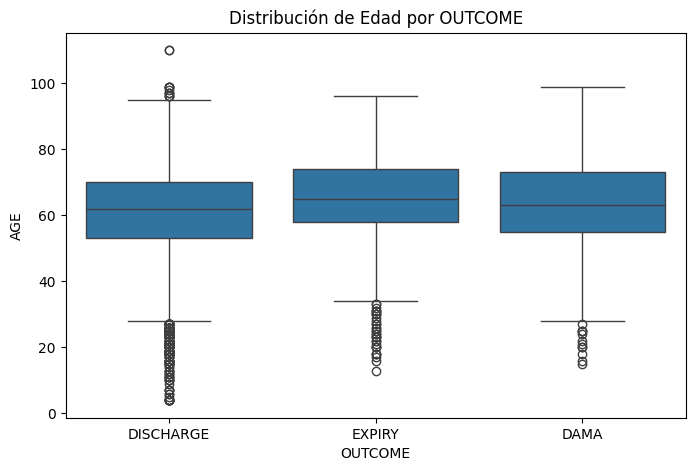

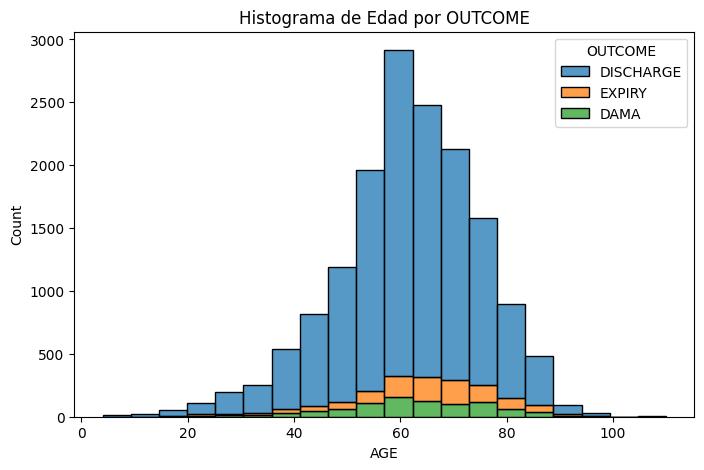

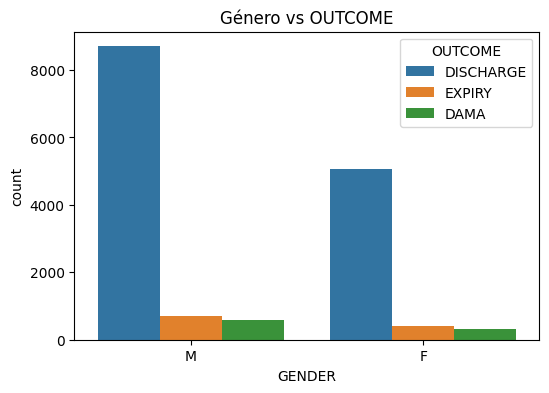

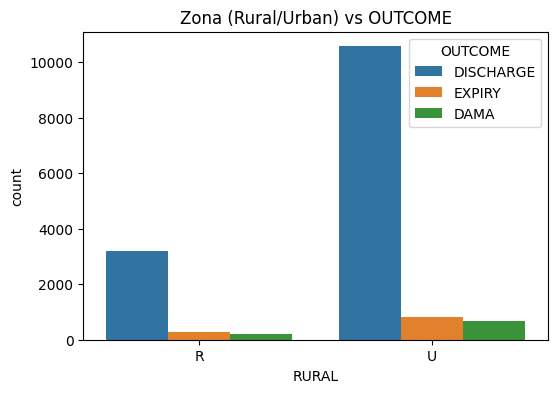

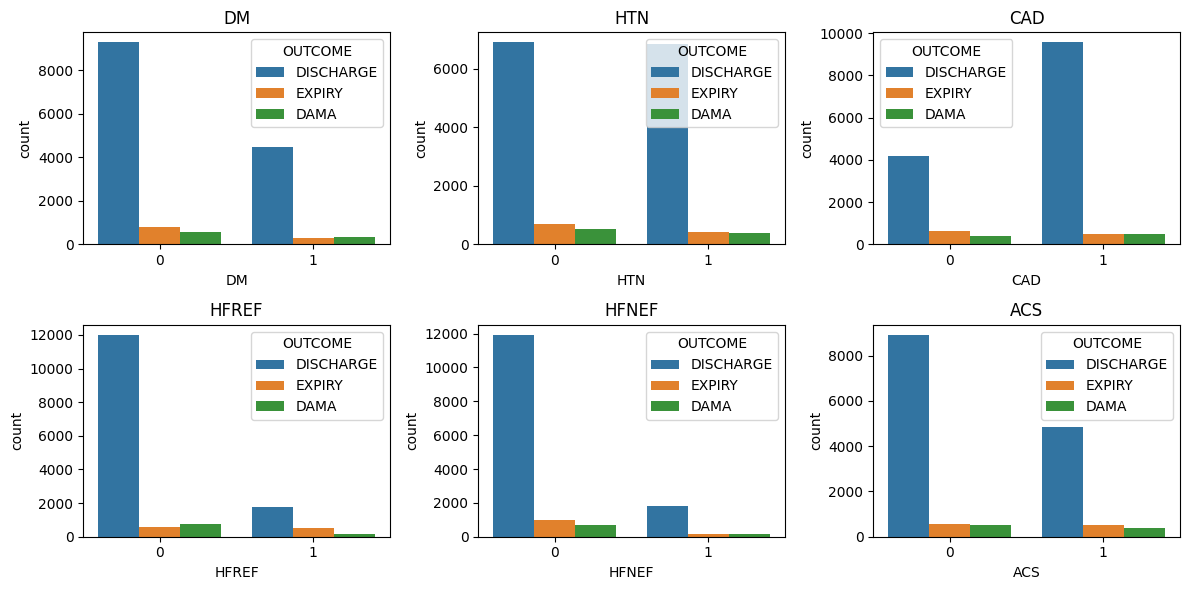

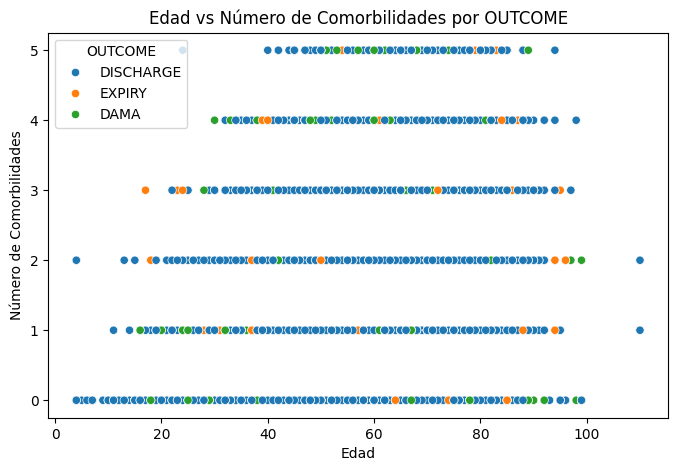

In [9]:
# ===============================
# 1️⃣ Edad
# ===============================
plt.figure(figsize=(8,5))
sns.boxplot(x='OUTCOME', y='AGE', data=df_adm)
plt.title("Distribución de Edad por OUTCOME")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df_adm, x='AGE', hue='OUTCOME', multiple='stack', bins=20)
plt.title("Histograma de Edad por OUTCOME")
plt.show()

# ===============================
# 2️⃣ Género
# ===============================
plt.figure(figsize=(6,4))
sns.countplot(x='GENDER', hue='OUTCOME', data=df_adm)
plt.title("Género vs OUTCOME")
plt.show()

# ===============================
# 3️⃣ Zona
# ===============================
plt.figure(figsize=(6,4))
sns.countplot(x='RURAL', hue='OUTCOME', data=df_adm)
plt.title("Zona (Rural/Urban) vs OUTCOME")
plt.show()

# ===============================
# 4️⃣ Comorbilidades
# ===============================
comorbidities = ['DM','HTN','CAD','HFREF','HFNEF','ACS']

plt.figure(figsize=(12,6))
for i, col in enumerate(comorbidities):
    plt.subplot(2,3,i+1)
    sns.countplot(x=col, hue='OUTCOME', data=df_adm)
    plt.title(col)
plt.tight_layout()
plt.show()

# ===============================
# 5️⃣ Combinación: Edad vs Número de Comorbilidades
# ===============================
# Crear columna temporal con número de comorbilidades (solo para visualización)
df_adm['num_comorbidities'] = df_adm[comorbidities].sum(axis=1)

plt.figure(figsize=(8,5))
sns.scatterplot(x='AGE', y='num_comorbidities', hue='OUTCOME', data=df_adm)
plt.title("Edad vs Número de Comorbilidades por OUTCOME")
plt.xlabel("Edad")
plt.ylabel("Número de Comorbilidades")
plt.show()

# Borrar columna temporal si quieres mantener el dataset original intacto
df_adm.drop(columns=['num_comorbidities'], inplace=True)

Analisis de df mortabily

In [10]:
# Limpiar nombres de columna: quitar espacios y caracteres extraños, poner todo en minúsculas
df_mor.columns = df_mor.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('ï»¿','')

# Revisar columnas
print(df_mor.columns)


Index(['s.no', 'mrd', 'age', 'gender', 'rural/urban', 'date_of_brought_dead'], dtype='object')



=== Frecuencia de género en df_mor ===
gender
M    236
F    123
Name: count, dtype: int64


/tmp/ipython-input-3311398908.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=df_mor, palette='pastel')


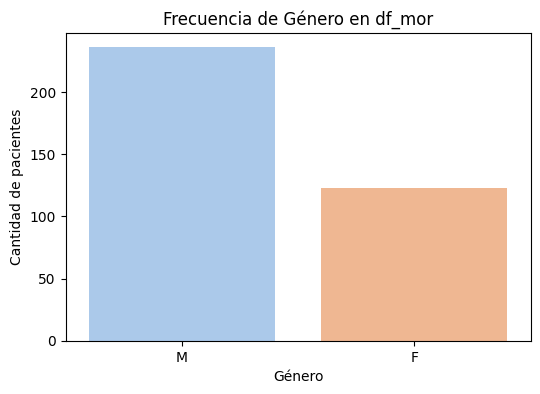

/tmp/ipython-input-3311398908.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rural/urban', data=df_mor, palette='muted')


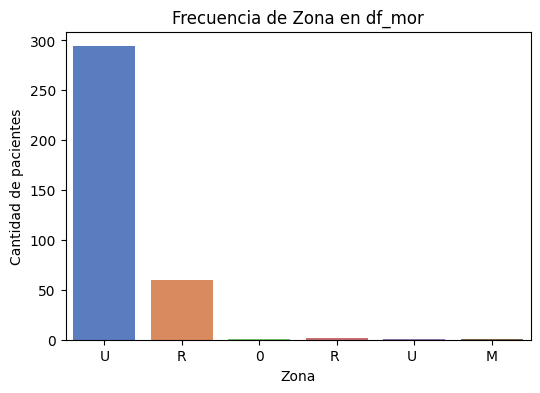


=== Frecuencia de zona (RURAL/URBAN) en df_mor ===
rural/urban
U     294
R      60
R       2
0       1
U       1
M       1
Name: count, dtype: int64


In [11]:
# Frecuencia de género
print("\n=== Frecuencia de género en df_mor ===")
print(df_mor['gender'].value_counts())


# ===============================
# Frecuencia de género
# ===============================
plt.figure(figsize=(6,4))
sns.countplot(x='gender', data=df_mor, palette='pastel')
plt.title("Frecuencia de Género en df_mor")
plt.xlabel("Género")
plt.ylabel("Cantidad de pacientes")
plt.show()

# ===============================
# Frecuencia de zona (RURAL/URBAN)
# ===============================
plt.figure(figsize=(6,4))
sns.countplot(x='rural/urban', data=df_mor, palette='muted')
plt.title("Frecuencia de Zona en df_mor")
plt.xlabel("Zona")
plt.ylabel("Cantidad de pacientes")
plt.show()
# Frecuencia de zona
print("\n=== Frecuencia de zona (RURAL/URBAN) en df_mor ===")
print(df_mor['rural/urban'].value_counts())

Valores en la comuna zona que se repiten o inválidos

Analisis dataset pollution

In [12]:
# Limpiar columnas: todo en minúscula, sin espacios
df_pol.columns = df_pol.columns.str.strip().str.lower().str.replace(' ', '_')

# Revisar nombres reales
print(df_pol.columns.tolist())

['ï»¿date', 'aqi', 'pm2.5_avg', 'pm2.5_min', 'pm2.5_max', 'pm10_avg', 'pm10_min', 'pm10_max', 'no2_avg', 'no2_min', 'no2_max', 'nh3_avg', 'nh3_min', 'nh3_max', 'so2_avg', 'so2_min', 'so2_max', 'co_avg', 'co_min', 'co_max', 'ozone_avg', 'ozone_min', 'ozone_max', 'prominent_pollutent', 'max_temp', 'min_temp', 'humidity']


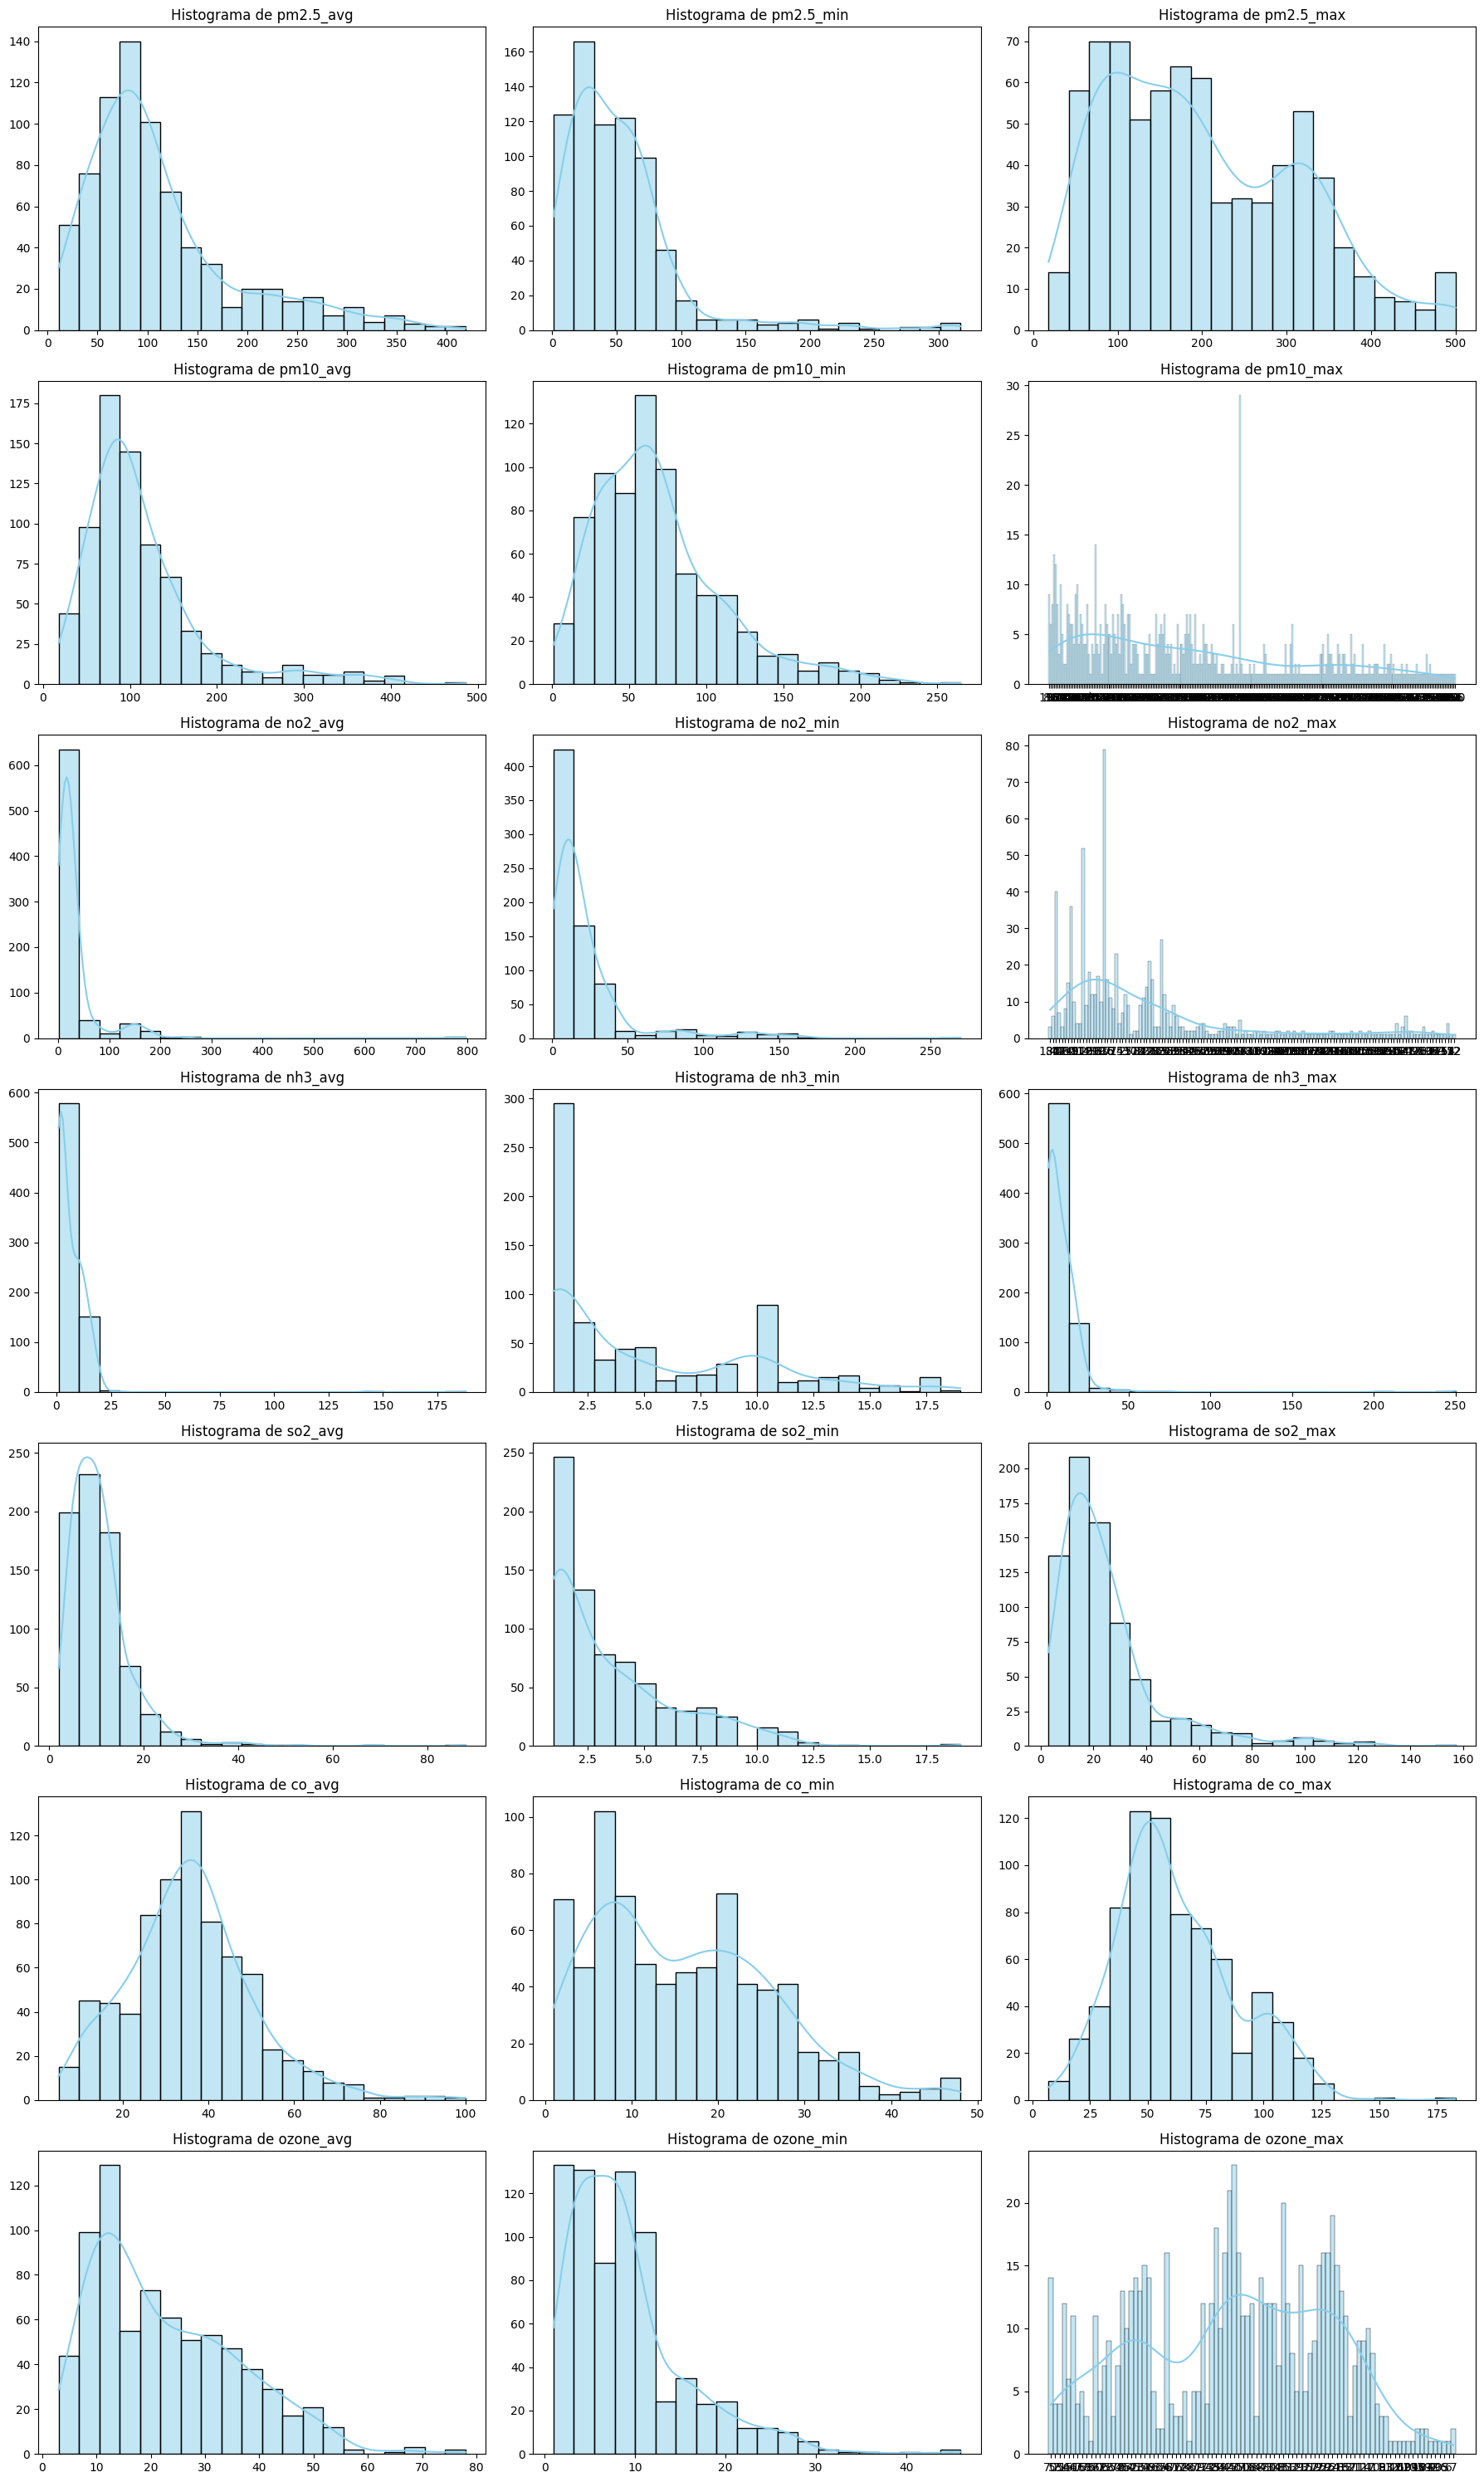

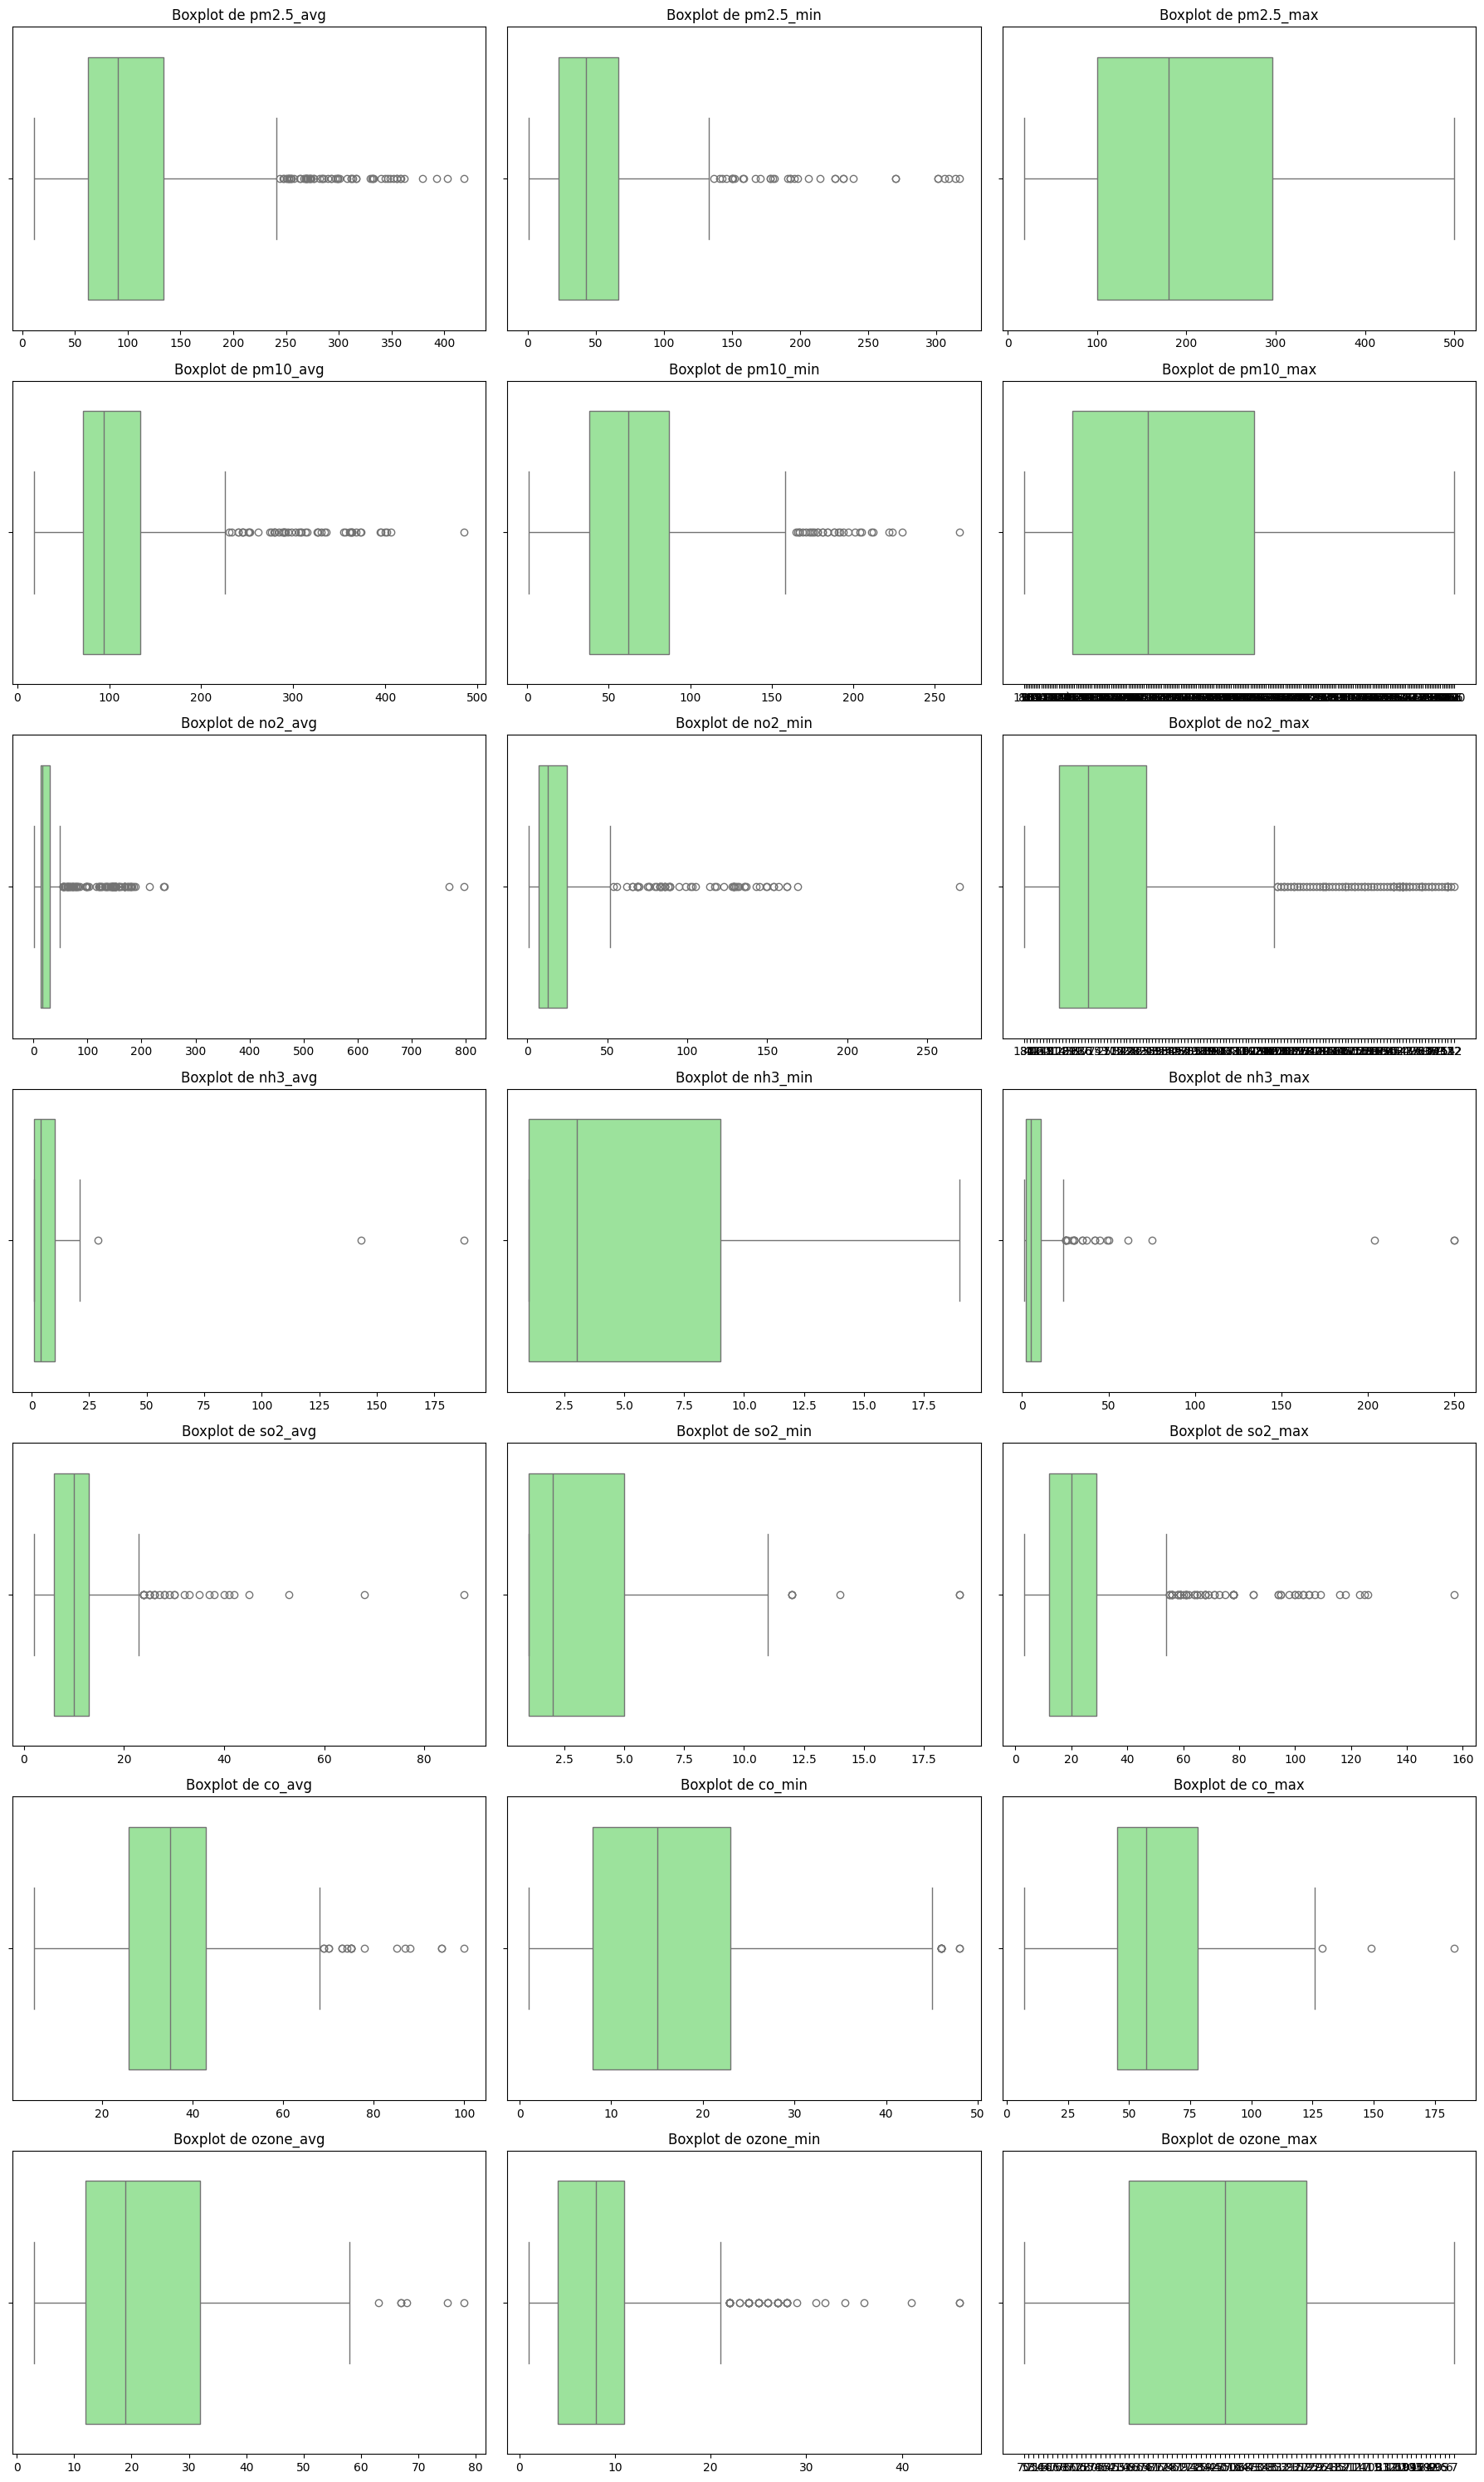

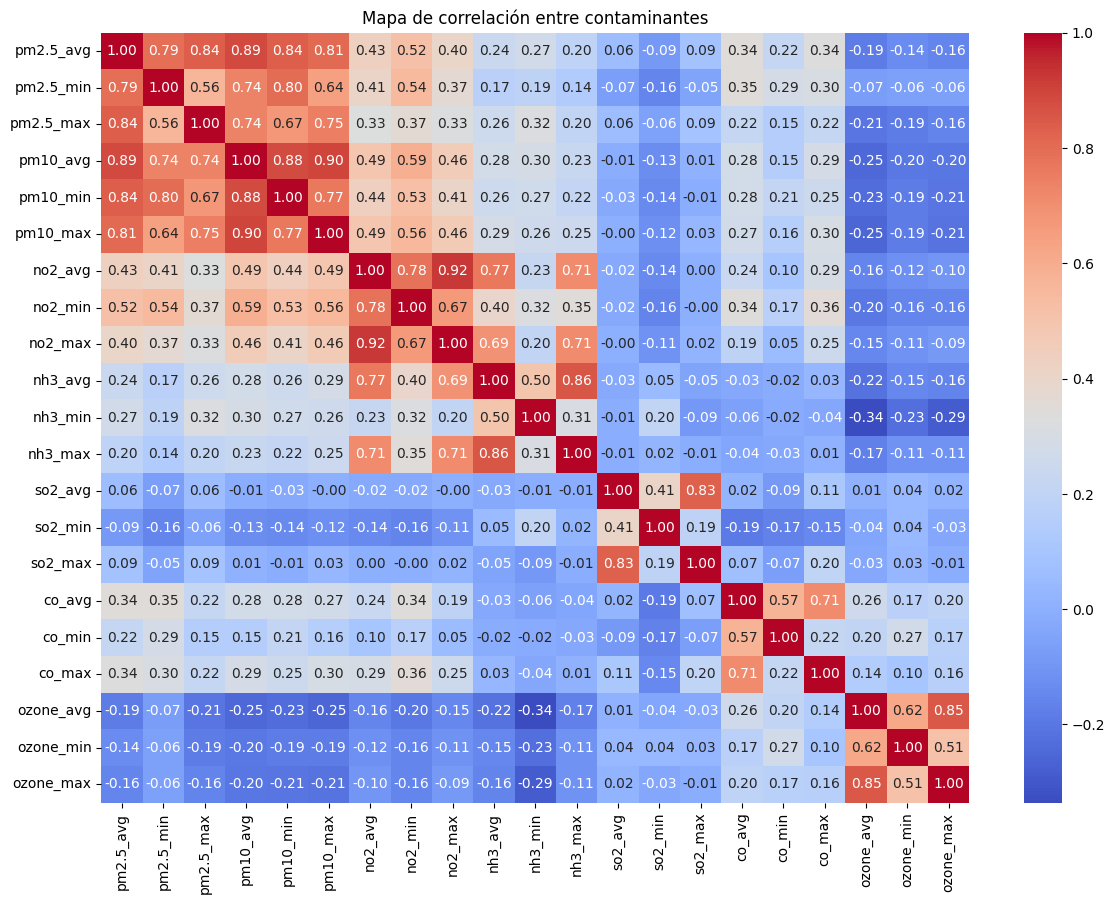

In [13]:

# ===============================
# Definir columnas de contaminantes
# ===============================
contaminantes = ['pm2.5_avg','pm2.5_min','pm2.5_max',
                 'pm10_avg','pm10_min','pm10_max',
                 'no2_avg','no2_min','no2_max',
                 'nh3_avg','nh3_min','nh3_max',
                 'so2_avg','so2_min','so2_max',
                 'co_avg','co_min','co_max',
                 'ozone_avg','ozone_min','ozone_max']

# ===============================
# Histogramas en subplots (3 por fila)
# ===============================
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(18, 30))  # 21 columnas = 7 filas x 3
axes = axes.flatten()

for i, col in enumerate(contaminantes):
    sns.histplot(df_pol[col], bins=20, kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f"Histograma de {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Quitar gráficos vacíos si sobran
for j in range(len(contaminantes), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# ===============================
# Boxplots en subplots (3 por fila)
# ===============================
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(18, 30))
axes = axes.flatten()

for i, col in enumerate(contaminantes):
    sns.boxplot(x=df_pol[col], color='lightgreen', ax=axes[i])
    axes[i].set_title(f"Boxplot de {col}")
    axes[i].set_xlabel("")

# Quitar gráficos vacíos si sobran
for j in range(len(contaminantes), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# ===============================
# Heatmap de correlación
# ===============================
df_pol[contaminantes] = df_pol[contaminantes].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(14,10))
sns.heatmap(df_pol[contaminantes].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Mapa de correlación entre contaminantes")
plt.show()


Combinacion de tablas

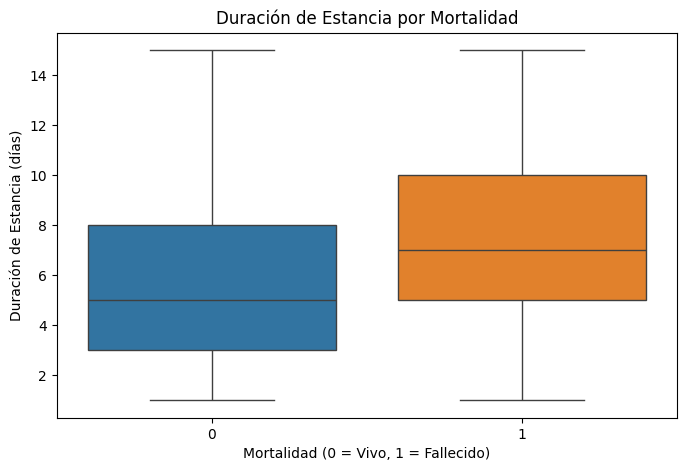

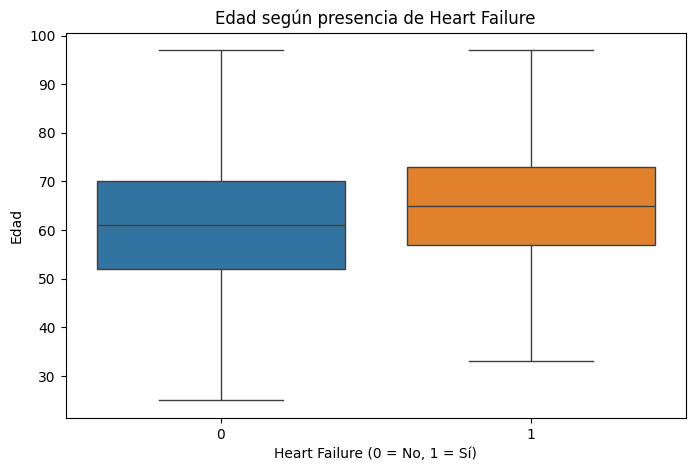

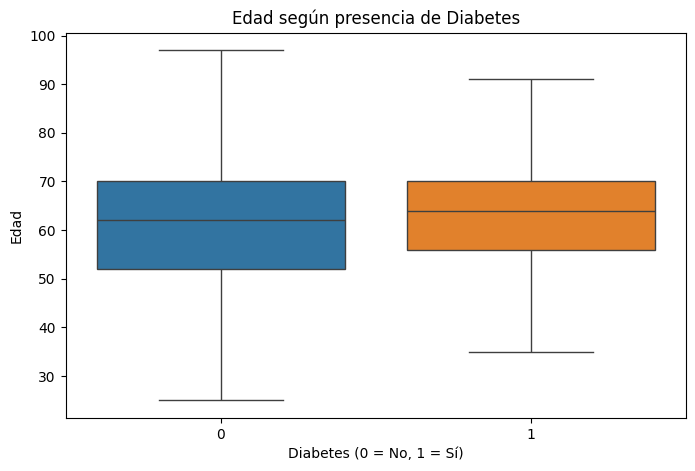

In [14]:
# Clean column names in df_adm and df_mor
df_adm.columns = df_adm.columns.str.replace('ï»¿','').str.strip().str.lower().str.replace(" ", "_")
df_mor.columns = df_mor.columns.str.replace('ï»¿','').str.strip().str.lower().str.replace(" ", "_")

# Rename columns in df_adm for merging
df_adm.rename(columns={'mrd_no.': 'mrd'}, inplace=True)

df_mor["murio"] = 1
df_adm_mor = df_adm.merge(
    df_mor[["mrd","murio"]],
    left_on="mrd", right_on="mrd",
    how="left"
)

# Mortalidad final (death en Outcome o aparece en Mortality)
df_adm_mor["murio"] = df_adm_mor["murio"].fillna(0)
df_adm_mor["murio_final"] = (
    (df_adm_mor["murio"] == 1) |
    (df_adm_mor["outcome"].astype(str).str.lower().str.contains("death"))
).astype(int)

# Ensure columns are numeric for plotting
df_adm_mor['heart_failure'] = pd.to_numeric(df_adm_mor['heart_failure'], errors='coerce')
df_adm_mor['dm'] = pd.to_numeric(df_adm_mor['dm'], errors='coerce')


# -----------------------------
# 1️⃣ Boxplot: Duración de estancia vs Mortalidad
# -----------------------------
plt.figure(figsize=(8,5))
sns.boxplot(x='murio_final', y='duration_of_stay', data=df_adm_mor, hue='murio_final', showfliers=False, legend=False)
plt.title("Duración de Estancia por Mortalidad")
plt.xlabel("Mortalidad (0 = Vivo, 1 = Fallecido)")
plt.ylabel("Duración de Estancia (días)")
plt.show()

# -----------------------------
# 2️⃣ Boxplot: Edad vs Heart Failure
# -----------------------------
plt.figure(figsize=(8,5))
sns.boxplot(x='heart_failure', y='age', data=df_adm_mor, hue='heart_failure', showfliers=False, legend=False)
plt.title("Edad según presencia de Heart Failure")
plt.xlabel("Heart Failure (0 = No, 1 = Sí)")
plt.ylabel("Edad")
plt.show()

# -----------------------------
# 3️⃣ Boxplot: Edad vs Diabetes
# -----------------------------
plt.figure(figsize=(8,5))
sns.boxplot(x='dm', y='age', data=df_adm_mor, hue='dm', showfliers=False, legend=False)
plt.title("Edad según presencia de Diabetes")
plt.xlabel("Diabetes (0 = No, 1 = Sí)")
plt.ylabel("Edad")
plt.show()

Analisis de correlaciones

In [15]:
# ============================
# 1. Preparación de mortalidad
# ============================

# Clean column names in df_adm
df_adm.columns = df_adm.columns.str.replace('ï»¿','').str.strip().str.lower().str.replace(" ", "_")
df_mor.columns = df_mor.columns.str.replace('ï»¿','').str.strip().str.lower().str.replace(" ", "_")

# Rename columns in df_adm for merging
df_adm.rename(columns={'mrd_no.': 'mrd'}, inplace=True)

df_mor["murio"] = 1
df_adm_mor = df_adm.merge(
    df_mor[["mrd","murio"]],
    left_on="mrd", right_on="mrd",
    how="left"
)

# Mortalidad final (death en Outcome o aparece en Mortality)
df_adm_mor["murio"] = df_adm_mor["murio"].fillna(0)
df_adm_mor["murio_final"] = (
    (df_adm_mor["murio"] == 1) |
    (df_adm_mor["outcome"].astype(str).str.lower().str.contains("death"))
).astype(int)

# ============================
# 2. Normalizar variables
# ============================
df_num = df_adm_mor.copy()

# Convertir comorbilidades and chest_infection to numeric
cols_to_numeric = ["smoking","alcohol","dm","htn","cad","ckd","anaemia",
                 "heart_failure","acs","stemi","cva_infract","cva_bleed", "chest_infection"]

for col in cols_to_numeric:
    if col in df_num.columns:
        df_num[col] = pd.to_numeric(df_num[col], errors='coerce')

# ============================
# 3. Calcular correlaciones
# ============================
# Select only numeric columns for correlation
df_num_corr = df_num.select_dtypes(include=['number'])
corrs = df_num_corr.corr()["murio_final"].drop("murio_final").sort_values(ascending=False)

# Top 10 correlaciones
top10 = corrs.head(10)
print("=== Top 10 correlaciones con mortalidad ===")
print(top10)

=== Top 10 correlaciones con mortalidad ===
murio                     1.000000
infective_endocarditis    0.067100
heart_failure             0.036250
hfnef                     0.032718
prior_cmp                 0.030687
dm                        0.026223
ckd                       0.022465
duration_of_stay          0.017213
age                       0.016182
hfref                     0.014298
Name: murio_final, dtype: float64


Observaciones del Top 10

* Infective Endocarditis → 0.067

Es la variable más correlacionada con mortalidad. Esto tiene sentido, ya que es una infección grave del corazón que puede ser letal.

* Heart Failure / HFNEF / Prior CMP / DM / CKD

Todas son enfermedades crónicas o antecedentes cardíacos, lo que concuerda con tu hipótesis de que las comorbilidades aumentan riesgo de desenlace negativo.

* Platelets, Duration_of_stay, Age

Valores numéricos más débiles, pero muestran cierta relación: pacientes mayores, con estancias más largas o alteraciones en plaquetas, pueden tener más riesgo.

# 3️⃣Preparación de los datos

###Limpieza

In [16]:
#limpieza de caracteres extraños, munisculas, uso de guion bajo en vez de espacios
def clean_columns(df):
    df.columns = df.columns.str.replace('ï»¿','').str.strip().str.lower().str.replace(" ", "_")
    return df

df_adm = clean_columns(df_adm)
df_mor = clean_columns(df_mor)
df_pol = clean_columns(df_pol)


In [17]:
# Convertir columnas de fecha
df_adm['d.o.a'] = pd.to_datetime(df_adm['d.o.a'], errors='coerce')
df_adm['d.o.d'] = pd.to_datetime(df_adm['d.o.d'], errors='coerce')
df_mor['date_of_brought_dead'] = pd.to_datetime(df_mor['date_of_brought_dead'], errors='coerce')
df_pol['date'] = pd.to_datetime(df_pol['date'], errors='coerce')

# renombrar columnas para mayor comprension
df_adm.rename(columns={'d.o.a':'date_of_admission', 'd.o.d':'date_of_discharge'}, inplace=True)

In [18]:
#conversion de columnas numericas que aparecian como tipo object
for col in ['hb','tlc','platelets','glucose','urea','creatinine','bnp','ef']:
    if col in df_adm.columns:
        df_adm[col] = pd.to_numeric(df_adm[col], errors='coerce')

for col in ['pm10_max','no2_max','ozone_max']:
    if col in df_pol.columns:
        df_pol[col] = pd.to_numeric(df_pol[col], errors='coerce')


Antes de tratar valores nulos, analizamos las columnas

In [19]:
# Columnas con nulos en df_adm
adm_null_cols = ['hb','tlc','platelets','glucose','urea','creatinine','bnp','ef']
print("===== Estadísticas columnas df_adm con nulos =====")
print(df_adm[adm_null_cols].describe())

# Columnas con nulos en df_pol
pol_null_cols = ['humidity']
print("\n===== Estadísticas columnas df_pol con nulos =====")
print(df_pol[pol_null_cols].describe())


===== Estadísticas columnas df_adm con nulos =====
                 hb           tlc     platelets       glucose          urea  \
count  15501.000000  15467.000000  15463.000000  14812.000000  15513.000000   
mean      12.220635     11.524977    238.617025    162.902795     50.161188   
std        2.327900      7.472741    103.827157     84.371718     42.494672   
min        3.000000      0.100000      0.580000      1.200000      0.100000   
25%       10.700000      7.900000    171.000000    106.000000     25.000000   
50%       12.400000     10.100000    226.000000    136.000000     35.000000   
75%       13.900000     13.400000    288.000000    196.000000     58.000000   
max       26.500000    314.000000   1179.000000    888.000000    495.000000   

         creatinine          bnp            ef  
count  15506.000000  6676.000000  14158.000000  
mean       1.343636   817.847244     43.461252  
std        1.197744   997.756165     13.467014  
min        0.065000     4.000000     14.0

In [20]:
# LIMPIEZA E IMPUTACIÓN DE NULOS
# --- Admission (df_adm) ---
# Columnas con pocos nulos → imputar con mediana
for col in ['hb','tlc','platelets','glucose','urea','creatinine','ef']:
    if col in df_adm.columns:
        median_value = df_adm[col].median()
        df_adm[col].fillna(median_value, inplace=True)
        print(f"Columna {col}: valores nulos imputados con mediana = {median_value}")

# Columnas con muchos nulos → eliminar del análisis inicial
if 'bnp' in df_adm.columns:
    df_adm.drop(columns=['bnp'], inplace=True)
    print("Columna BNP eliminada por tener demasiados valores nulos.")

# --- Pollution (df_pol) ---
# HUMIDITY: pocos nulos → imputar con media
if 'humidity' in df_pol.columns:
    mean_value = df_pol['humidity'].mean()
    df_pol['humidity'].fillna(mean_value, inplace=True)
    print(f"Columna HUMIDITY: valores nulos imputados con media = {mean_value:.2f}")

# --- Mortality (df_mor) ---
# No tiene nulos, nada que hacer
print("Mortality dataset no tiene valores nulos.")

# --- Confirmar limpieza ---
print("\nValores nulos restantes en df_adm:\n", df_adm.isnull().sum())
print("\nValores nulos restantes en df_pol:\n", df_pol.isnull().sum())
print("\nValores nulos restantes en df_mor:\n", df_mor.isnull().sum())


Columna hb: valores nulos imputados con mediana = 12.4
Columna tlc: valores nulos imputados con mediana = 10.1
Columna platelets: valores nulos imputados con mediana = 226.0
Columna glucose: valores nulos imputados con mediana = 136.0
Columna urea: valores nulos imputados con mediana = 35.0
Columna creatinine: valores nulos imputados con mediana = 1.0
Columna ef: valores nulos imputados con mediana = 42.0
Columna BNP eliminada por tener demasiados valores nulos.
Columna HUMIDITY: valores nulos imputados con media = 40.62
Mortality dataset no tiene valores nulos.

Valores nulos restantes en df_adm:
 sno                                   0
mrd                                   0
date_of_admission                  5655
date_of_discharge                  5550
age                                   0
gender                                0
rural                                 0
type_of_admission-emergency/opd       0
month_year                            0
duration_of_stay                  

/tmp/ipython-input-185793229.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_adm[col].fillna(median_value, inplace=True)
/tmp/ipython-input-185793229.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [21]:
# Normalizar valores de rural/urban porque habian valores q se repetian
df_mor['rural/urban_clean'] = df_mor['rural/urban'].str.upper()  # todo en mayúscula
df_mor['rural/urban_clean'] = df_mor['rural/urban_clean'].replace({'0': None, 'M': None})  # convertir valores incorrectos a NaN


In [22]:
# 2️⃣ Diabetes Mellitus (DM)
df_adm_mor['DIABETES'] = df_adm_mor['dm'].fillna(0).apply(lambda x: 1 if x>0 else 0)

In [23]:
# 3️⃣ Hipertensión (HTN)
df_adm_mor['HIPERTENSION'] = df_adm_mor['htn'].fillna(0).apply(lambda x: 1 if x>0 else 0)

In [24]:
# 4️⃣ Insuficiencia renal (CKD)
df_adm_mor['INSUF_RENAL'] = df_adm_mor['ckd'].fillna(0).apply(lambda x: 1 if x>0 else 0)

In [25]:
# 5️⃣ Enfermedad cerebrovascular (CVA)
cva_cols = ['cva_infract', 'cva_bleed']
df_adm_mor['ENF_CEREBROVASCULAR'] = df_adm_mor[cva_cols].fillna(0).sum(axis=1)
df_adm_mor['ENF_CEREBROVASCULAR'] = df_adm_mor['ENF_CEREBROVASCULAR'].apply(lambda x: 1 if x>0 else 0)

In [26]:
# 6️⃣ Insuficiencia cardíaca
df_adm_mor['INSUF_CARDIACA'] = df_adm_mor['heart_failure'].fillna(0).apply(lambda x: 1 if x>0 else 0)

In [27]:
df_adm_mor.head(10)

,sno,mrd,d.o.a,d.o.d,age,gender,rural,type_of_admission-emergency/opd,month_year,duration_of_stay,...,shock,pulmonary_embolism,chest_infection,murio,murio_final,DIABETES,HIPERTENSION,INSUF_RENAL,ENF_CEREBROVASCULAR,INSUF_CARDIACA
0,1,234735,4/1/2017,4/3/2017,81,M,R,E,Apr-17,3,...,0,0,0,0.0,0,1,0,0,0,1
1,2,234696,4/1/2017,4/5/2017,65,M,R,E,Apr-17,5,...,0,0,0,0.0,0,0,1,0,0,0
2,3,234882,4/1/2017,4/3/2017,53,M,U,E,Apr-17,3,...,0,0,0,0.0,0,1,0,0,0,1
3,4,234635,4/1/2017,4/8/2017,67,F,U,E,Apr-17,8,...,0,0,0,0.0,0,0,1,0,0,0
4,5,234486,4/1/2017,4/23/2017,60,F,U,E,Apr-17,23,...,0,0,0,0.0,0,0,1,0,0,0
5,6,234675,4/1/2017,4/10/2017,44,M,U,E,Apr-17,10,...,0,0,0,0.0,0,1,1,0,0,1
6,7,234563,4/1/2017,4/6/2017,56,F,U,E,Apr-17,6,...,0,0,0,0.0,0,1,1,0,0,1
7,8,208455,4/1/2017,4/13/2017,47,M,U,E,Apr-17,13,...,0,0,0,0.0,0,1,1,0,0,0
8,9,67070,4/1/2017,4/3/2017,65,F,U,E,Apr-17,3,...,1,0,0,0.0,0,0,1,0,0,1
9,10,153218,4/1/2017,4/3/2017,59,M,U,E,Apr-17,3,...,0,0,0,0.0,0,1,1,0,0,0


In [28]:
df_adm_mor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15758 entries, 0 to 15757
Data columns (total 63 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   sno                              15758 non-null  int64  
 1   mrd                              15758 non-null  object 
 2   d.o.a                            15758 non-null  object 
 3   d.o.d                            15758 non-null  object 
 4   age                              15758 non-null  int64  
 5   gender                           15758 non-null  object 
 6   rural                            15758 non-null  object 
 7   type_of_admission-emergency/opd  15758 non-null  object 
 8   month_year                       15758 non-null  object 
 9   duration_of_stay                 15758 non-null  int64  
 10  duration_of_intensive_unit_stay  15758 non-null  int64  
 11  outcome                          15758 non-null  object 
 12  smoking           

###Eliminacion de outliers

In [29]:
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[columna] < lower) | (df[columna] > upper)]
    print(f"Columna: {columna}")
    print(f"Rango aceptado: [{lower:.2f}, {upper:.2f}]")
    print(f"Cantidad de outliers: {len(outliers)}")
    return outliers

# Ejemplo con edad
outliers_age = detectar_outliers(df_adm_mor, "age")

# Ejemplo con duración de estancia
outliers_stay = detectar_outliers(df_adm_mor, "duration_of_stay")

Columna: age
Rango aceptado: [30.00, 94.00]
Cantidad de outliers: 362
Columna: duration_of_stay
Rango aceptado: [-4.50, 15.50]
Cantidad de outliers: 736


In [30]:
for col in df_adm_mor.select_dtypes(include=["float64", "int64"]).columns:
    detectar_outliers(df_adm_mor, col)
    print("-"*40)

Columna: sno
Rango aceptado: [-7876.00, 23634.00]
Cantidad de outliers: 0
----------------------------------------
Columna: age
Rango aceptado: [30.00, 94.00]
Cantidad de outliers: 362
----------------------------------------
Columna: duration_of_stay
Rango aceptado: [-4.50, 15.50]
Cantidad de outliers: 736
----------------------------------------
Columna: duration_of_intensive_unit_stay
Rango aceptado: [-5.00, 11.00]
Cantidad de outliers: 683
----------------------------------------
Columna: smoking
Rango aceptado: [0.00, 0.00]
Cantidad de outliers: 793
----------------------------------------
Columna: alcohol
Rango aceptado: [0.00, 0.00]
Cantidad de outliers: 1021
----------------------------------------
Columna: dm
Rango aceptado: [-1.50, 2.50]
Cantidad de outliers: 0
----------------------------------------
Columna: htn
Rango aceptado: [-1.50, 2.50]
Cantidad de outliers: 0
----------------------------------------
Columna: cad
Rango aceptado: [-1.50, 2.50]
Cantidad de outliers: 0
--

Se eliminan outliers de edad menor a 20 y mayor a 100
Se eliminan outliers de duracion de estadia negativos y valores mayor a 100 dias
Se eliminan outliers de duracion de estadia en uci, negativos y mayores a 60 dias

In [31]:
# -----------------------------
# 🔹 Eliminación de outliers
# -----------------------------

# 1. Edad: eliminar < 20 o > 100
df_adm_mor = df_adm_mor[(df_adm_mor['age'] >= 20) & (df_adm_mor['age'] <= 100)]

# 2. Duración de estancia: eliminar negativos o > 100
df_adm_mor = df_adm_mor[(df_adm_mor['duration_of_stay'] >= 0) & (df_adm_mor['duration_of_stay'] <= 100)]

# 3. Duración en UCI: eliminar negativos o > 60
df_adm_mor = df_adm_mor[(df_adm_mor['duration_of_intensive_unit_stay'] >= 0) & (df_adm_mor['duration_of_intensive_unit_stay'] <= 60)]

# Resetear índice tras limpieza
df_adm_mor = df_adm_mor.reset_index(drop=True)

print("✅ Shape final después de limpiar:", df_adm_mor.shape)

✅ Shape final después de limpiar: (15672, 63)


In [32]:
df_adm_mor.head(10)

,sno,mrd,d.o.a,d.o.d,age,gender,rural,type_of_admission-emergency/opd,month_year,duration_of_stay,...,shock,pulmonary_embolism,chest_infection,murio,murio_final,DIABETES,HIPERTENSION,INSUF_RENAL,ENF_CEREBROVASCULAR,INSUF_CARDIACA
0,1,234735,4/1/2017,4/3/2017,81,M,R,E,Apr-17,3,...,0,0,0,0.0,0,1,0,0,0,1
1,2,234696,4/1/2017,4/5/2017,65,M,R,E,Apr-17,5,...,0,0,0,0.0,0,0,1,0,0,0
2,3,234882,4/1/2017,4/3/2017,53,M,U,E,Apr-17,3,...,0,0,0,0.0,0,1,0,0,0,1
3,4,234635,4/1/2017,4/8/2017,67,F,U,E,Apr-17,8,...,0,0,0,0.0,0,0,1,0,0,0
4,5,234486,4/1/2017,4/23/2017,60,F,U,E,Apr-17,23,...,0,0,0,0.0,0,0,1,0,0,0
5,6,234675,4/1/2017,4/10/2017,44,M,U,E,Apr-17,10,...,0,0,0,0.0,0,1,1,0,0,1
6,7,234563,4/1/2017,4/6/2017,56,F,U,E,Apr-17,6,...,0,0,0,0.0,0,1,1,0,0,1
7,8,208455,4/1/2017,4/13/2017,47,M,U,E,Apr-17,13,...,0,0,0,0.0,0,1,1,0,0,0
8,9,67070,4/1/2017,4/3/2017,65,F,U,E,Apr-17,3,...,1,0,0,0.0,0,0,1,0,0,1
9,10,153218,4/1/2017,4/3/2017,59,M,U,E,Apr-17,3,...,0,0,0,0.0,0,1,1,0,0,0


**MODELO1**

In [33]:
df_adm_mor = df_adm_mor.copy()  # por seguridad

In [42]:
# Variables independientes y target
X = df_adm_mor.drop(columns=["murio_final", "sno", "mrd", "d.o.a", "d.o.d", "month_year", "murio"])
y = df_adm_mor["murio_final"]

In [56]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [58]:
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include='object').columns

# Apply one-hot encoding
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Ensure all columns in X_test_encoded are in X_train_encoded (in case of missing categories in test set)
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for c in missing_cols:
    X_test_encoded[c] = 0
# Ensure the order of columns is the same
X_test_encoded = X_test_encoded[X_train_encoded.columns]


# Escalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

/tmp/ipython-input-2931001613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_encoded[c] = 0
/tmp/ipython-input-2931001613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_encoded[c] = 0
/tmp/ipython-input-2931001613.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_e

In [59]:
# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

In [60]:
from sklearn.neighbors import KNeighborsClassifier

# n_neighbors más pequeño y paralelización
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

In [61]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3 folds en lugar de 5
scores = cross_val_score(knn, X_train_res, y_train_res, cv=cv, scoring='f1', n_jobs=-1)

print("F1-score CV:", scores)
print("Mean F1:", scores.mean())


F1-score CV: [0.98404067 0.98485566 0.98056308]
Mean F1: 0.9831531346155656


In [62]:
knn.fit(X_train_res, y_train_res)
y_pred = knn.predict(X_test_scaled)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=["Vivo(0)", "Murió(1)"], columns=["Pred 0", "Pred 1"])
print(cm)


              precision    recall  f1-score   support

           0       1.00      0.97      0.99      3122
           1       0.04      0.23      0.06        13

    accuracy                           0.97      3135
   macro avg       0.52      0.60      0.52      3135
weighted avg       0.99      0.97      0.98      3135

          Pred 0  Pred 1
Vivo(0)     3040      82
Murió(1)      10       3
